I will apply one-hot encoding to all categorical features, without re-grouping. Then we will train a logistic regression and a tree-based model. 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix

In [5]:
df = pd.read_csv("unmodified.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      339 non-null    int64  
 1   formula         339 non-null    object 
 2   spacegroup      339 non-null    object 
 3   form_e          339 non-null    float64
 4   above_hull_e    339 non-null    float64
 5   band_gap_e      339 non-null    float64
 6   n_sites         339 non-null    int64  
 7   density         339 non-null    float64
 8   volume          339 non-null    float64
 9   has_bandstr     339 non-null    bool   
 10  crystal_system  339 non-null    object 
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 26.9+ KB


In [24]:
X = df.drop(columns=['crystal_system'])
y = df['crystal_system']

num_features = ['form_e', 'above_hull_e', 'band_gap_e', 'n_sites', 'density', 'volume']
cat_features = ['formula', 'spacegroup', 'has_bandstr']

# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

cat_transformer = OneHotEncoder(sparse=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', cat_transformer, cat_features)])

model_ = DecisionTreeClassifier()


model = Pipeline([
  ('preprocessor', preprocessor),
  ('classifier', model_)
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['form_e', 'above_hull_e',
                                                   'band_gap_e', 'n_sites',
                                                   'density', 'volume']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['formula', 'spacegroup',
                                                   'has_bandstr'])])),
                ('classifier', DecisionTreeClassifier())])

In [26]:
# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

ValueError: Found unknown categories ['Li5Co4(Si3O10)2', 'Li2Mn5(Si2O7)2', 'Li2Mn4Si4O13', 'Li2Mn2Si5O13', 'Li4Fe2SiO7', 'Li5Fe5Si7O24', 'LiMnSi3O8', 'LiCo3(SiO4)2', 'Li9Fe4(SiO5)4', 'Li2Fe5Si5O16', 'Li3Fe4(Si3O10)2', 'Li2Fe2Si5O13', 'Li9Mn5(SiO8)2', 'Li2Fe2Si4O11', 'Li4Fe3(SiO4)3', 'Li6Fe(SiO4)2', 'Li2Fe3(SiO4)2', 'Li3CoSiO5', 'Li2Mn2Si4O11', 'Li6Co(SiO4)2', 'LiFe3(SiO4)2', 'Li16Fe4SiO16', 'Li2Co3(SiO4)2', 'Li7Mn11(Si3O16)2', 'Li2Mn3(SiO4)2', 'Li15Mn15SiO32', 'Li2Co2SiO6', 'Li2Mn3(Si3O8)2', 'Li2Fe4Si4O13', 'Li17Fe6(Si2O7)6', 'Li4Fe(SiO4)2', 'Li2Mn5Si5O16', 'Li5Mn17(SiO16)2', 'Li2Fe3(Si3O8)2', 'Li2Fe5(Si2O7)2'] in column 0 during transform

So what's happening in the cell above is that it gave an error because we get different categories in train and test for our high cardinality categorical features. Different categories end up in different groups and when encoded, this results in a different amount of features on each side. This problem would be solved if we had a sufficient amount of samples for every category, which we don't. 

This can be solved in two ways. One would be to align train and test arrays so that they have the same number of features. This would discard categories that appear on train/test group and not on the other. This means that we would lose information so it's not the best option. 

The other way is to re-group the categories using field-knowledge. But this is a lazy approach and we don't want to learn about batteries. 

*Note: Using alingment shouldn't work in a production environment, where incoming data can contain different variations for categories.*

In [52]:
# We're going to align the train and test sets after we split them. 

X = df.drop(columns=['crystal_system'])
y = df['crystal_system']

num_features = ['form_e', 'above_hull_e', 'band_gap_e', 'n_sites', 'density', 'volume']
cat_features = ['formula', 'spacegroup', 'has_bandstr']

# Train and test
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

X_train_cat_encoded_ = pd.get_dummies(X_train_[cat_features])   
X_test_cat_encoded_ = pd.get_dummies(X_test_[cat_features])      
X_train_cat_encoded, X_test_cat_encoded = X_train_cat_encoded_.align(X_test_cat_encoded_, join='inner', axis=1)  # inner align
#X_train_cat_encoded, X_test_cat_encoded = X_train_cat_encoded_, X_test_cat_encoded_ # uncomment this to see align effects on shape prints (boxes below this one)

X_train = np.hstack((X_train_[num_features].values, X_train_cat_encoded))
X_test = np.hstack((X_test_[num_features].values, X_test_cat_encoded))


In [54]:
X_train.shape

(237, 65)

In [55]:
X_test.shape

(102, 65)

Now we can train a desition tree

In [56]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [57]:
# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

DescisionTreeClassifier - Train group classification report
              precision    recall  f1-score   support

  monoclinic       1.00      1.00      1.00        92
orthorhombic       1.00      1.00      1.00        89
   triclinic       1.00      1.00      1.00        56

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237

DescisionTreeClassifier - Test group classification report
              precision    recall  f1-score   support

  monoclinic       0.98      1.00      0.99        47
orthorhombic       1.00      0.97      0.99        39
   triclinic       1.00      1.00      1.00        16

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



d:\anaconda3\envs\neoland\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\anaconda3\envs\neoland\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'DescisionTreeClassifier - CM Test\n')

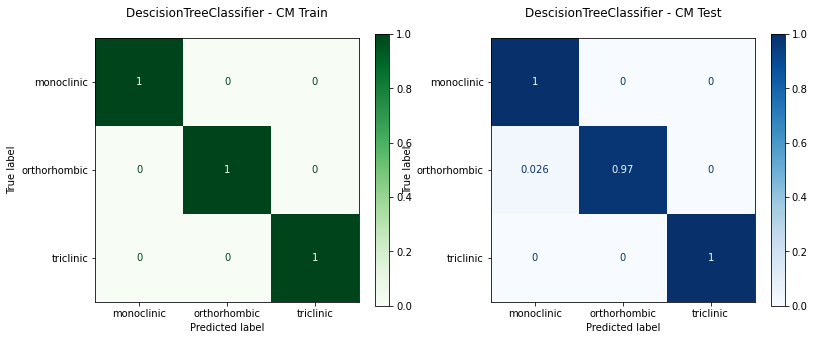

In [58]:
# Evaluate train
text = "DescisionTreeClassifier - Train group classification report" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

# Evaluate val
print(len(text)*"=")
print("DescisionTreeClassifier - Test group classification report")
print(len(text)*"=")
print(classification_report(y_test, y_test_pred))

fig, axes = plt.subplots(1,2, figsize=(13,5))

plot_confusion_matrix(ax=axes[0], estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Greens').ax_ \
                      .set_title('DescisionTreeClassifier - CM Train\n')

plot_confusion_matrix(ax=axes[1], estimator= model, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('DescisionTreeClassifier - CM Test\n')